# Mean-variance optimization

In this cookbook recipe, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities. I will discuss what I think should be your "default" options, based on my experience in optimising portfolios.

To start, you need a list of tickers. Some people just provide the whole universe of stocks, but I don't think this is a good idea - portfolio optimization is quite different from asset selection. I would suggest anywhere from 10-50 stocks as a starting point.

Some of the things we cover:

- Downloading data and getting it into PyPortfolioOpt
- Calculating and visualising the covariance matrix
- Optimising a long/short portfolio to minimise total variance
- Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
- Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
- Optimising a market-neutral portfolio to minimise risk for a given level of return
- Optimising along the mean-semivariance frontier
- Optimising along the mean-CVaR frontier
- Plotting the efficient frontier:
    - Simple (using CLA)
    - Constrained
    - Complex plots

Please consult the [docs](https://pyportfolioopt.readthedocs.io/) for more info.

## Downloading data

To download data, we will use `yfinance`, an excellent library that provides free price data from Yahoo Finance, no API key needed.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)

In [56]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils.plotting import EfficientFrontier,plot_covariance,plot_efficient_frontier


In [65]:
tickers = ["MSFT", "AMZN", "KO", "MA",
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           ] 

In [66]:
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
ohlc = yf.download(tickers, period="max")

[*********************100%%**********************]  9 of 9 completed


In [67]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.tail()

Ticker,AMZN,JPM,KO,LUV,MA,MSFT,PFE,UNH,XOM
Date,,,,,,,,,
2025-01-02,220.220001,238.766861,61.840000,33.369999,522.400024,418.579987,26.610001,504.510010,107.309998
2025-01-03,224.190002,242.029999,61.750000,33.610001,521.359985,423.350006,26.590000,513.000000,107.860001
2025-01-06,227.610001,240.850006,60.810001,33.830002,511.929993,427.850006,26.889999,513.669983,107.739998
2025-01-07,222.110001,243.169998,60.840000,32.880001,511.399994,422.369995,27.129999,514.250000,108.750000
2025-01-08,222.130005,243.130005,61.709999,32.880001,516.400024,424.559998,26.860001,524.520020,106.930000


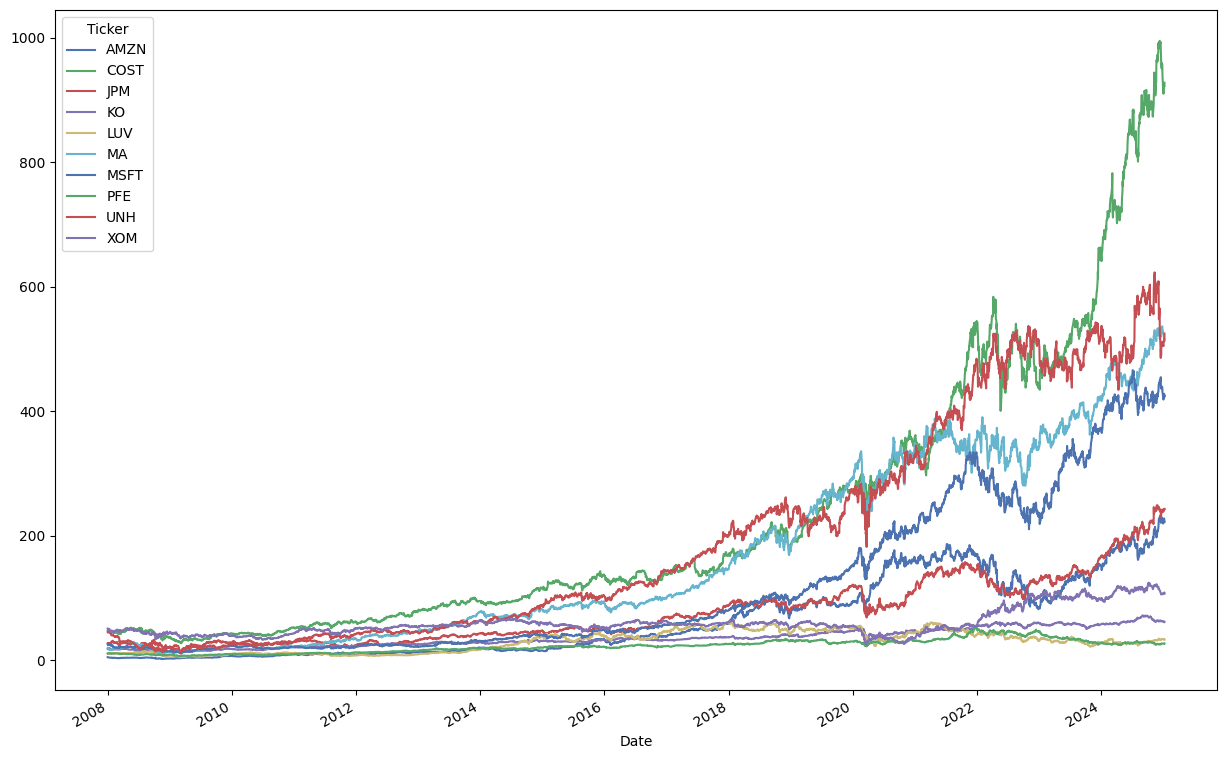

In [64]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

## Calculating the covariance matrix

In [7]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [68]:
from pypfopt import risk_models
from utils.plotting import EfficientFrontier,plot_covariance,plot_efficient_frontier

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov.values

array([[0.31283193, 0.06228599, 0.01892199, 0.04590933, 0.05320056,
        0.07109517, 0.0293373 , 0.03178623, 0.0247352 ],
       [0.06228599, 0.12425387, 0.02667218, 0.04788957, 0.06332177,
        0.04707248, 0.03159883, 0.03692765, 0.03241255],
       [0.01892199, 0.02667218, 0.05235206, 0.02201876, 0.02417154,
        0.02658098, 0.02534438, 0.0221915 , 0.02010912],
       [0.04590933, 0.04788957, 0.02201876, 0.13746657, 0.04506943,
        0.03550159, 0.02533374, 0.03104597, 0.02281246],
       [0.05320056, 0.06332177, 0.02417154, 0.04506943, 0.10821099,
        0.04629182, 0.02916218, 0.03844054, 0.03806096],
       [0.07109517, 0.04707248, 0.02658098, 0.03550159, 0.04629182,
        0.1114016 , 0.02939878, 0.03226519, 0.02735924],
       [0.0293373 , 0.03159883, 0.02534438, 0.02533374, 0.02916218,
        0.02939878, 0.07524035, 0.02725323, 0.02233714],
       [0.03178623, 0.03692765, 0.0221915 , 0.03104597, 0.03844054,
        0.03226519, 0.02725323, 0.1561509 , 0.02162929],


In [6]:
plot_covariance(sample_cov, plot_correlation=True);

For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

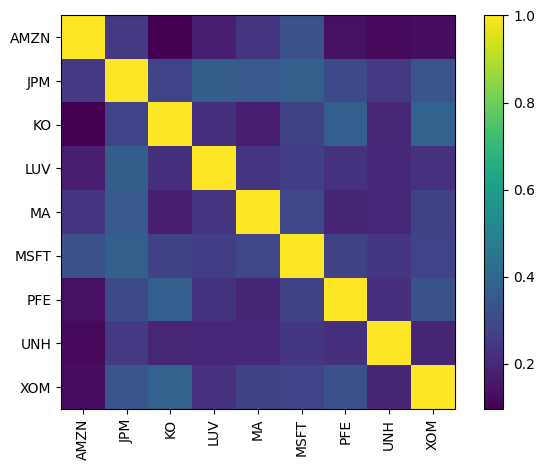

In [71]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plot_covariance(S, plot_correlation=True);

## Return estimation

As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Unless you have a proprietary method for estimating returns, research suggests that you may be better off not providing expected returns – you can then just find the `min_volatility()` portfolio or use `HRP`. 

However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. Please see the notebook `1-RiskReturnModels.ipynb` for more information.

In [72]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu.values

array([0.35310148, 0.2414856 , 0.14627218, 0.22597726, 0.24048163,
       0.23002561, 0.17666204, 0.22419407, 0.1403324 ])

In [8]:
mu

Ticker
ACN     0.202509
AMZN    0.340582
COST    0.188729
DIS     0.220284
F       0.223581
GILD    0.239770
JPM     0.243937
KO      0.144216
LUV     0.223220
MA      0.243863
MSFT    0.232273
PFE     0.172896
TSLA    0.289825
UNH     0.210516
XOM     0.138857
Name: mkt, dtype: float64

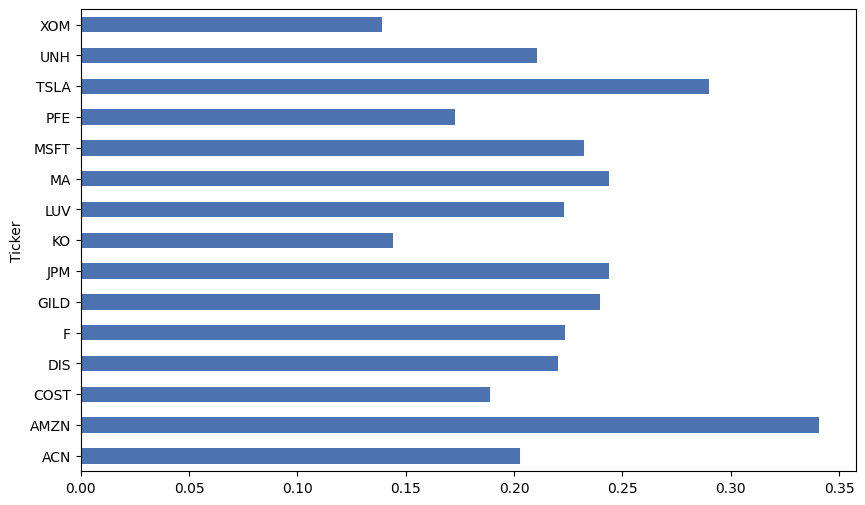

In [17]:
mu.plot.barh(figsize=(10,6));

## Long/short min variance

In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios.

In [68]:
from pypfopt import EfficientFrontier

In [9]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S.values, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
list(weights.values())

c:\Users\versu\anaconda3\envs\Thesis\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.00103,
 0.01595,
 -0.05823,
 -0.02266,
 -0.02146,
 0.03071,
 0.01365,
 -0.01102,
 -0.01346,
 0.53799,
 0.01544,
 -0.00183,
 -0.00409,
 0.01471,
 -0.01463,
 0.0453,
 -0.0354,
 0.02623,
 0.02406,
 0.00789,
 0.02586,
 0.00594,
 0.00435,
 0.05395,
 0.01542,
 0.01467,
 0.18206,
 0.09879,
 0.00791,
 0.04087]

[0.22563,
 0.00645,
 0.10043,
 -0.01991,
 -0.02336,
 0.05007,
 -0.04635,
 0.13789,
 0.0236,
 0.23845,
 -0.0015,
 0.07214,
 0.11144,
 0.03678,
 0.08825]

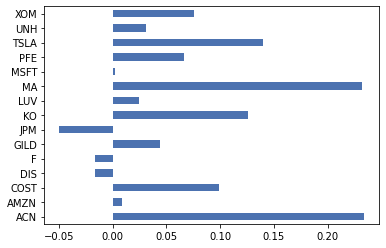

In [70]:
pd.Series(weights).plot.barh();

We can get a quick indication of the portfolio performance as follows. Note that this is an in sample estimate and may have very little resemblance to how the portfolio actually performs!

In [10]:
ef.portfolio_performance(verbose=True);

Annual volatility: 8.5%


In [72]:
prices

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,0.058398,NaN,NaN,NaN,0.051133,NaN,NaN,NaN,NaN,NaN,NaN,0.101854
1962-01-03,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.049994,NaN,NaN,NaN,NaN,NaN,NaN,0.103367
1962-01-04,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.050374,NaN,NaN,NaN,NaN,NaN,NaN,0.103619
1962-01-05,NaN,NaN,NaN,0.059378,NaN,NaN,NaN,0.049234,NaN,NaN,NaN,NaN,NaN,NaN,0.101350
1962-01-08,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.048728,NaN,NaN,NaN,NaN,NaN,NaN,0.101098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,343.959991,3158.709961,515.890015,142.509995,17.889999,63.759998,153.070007,61.599998,44.599998,376.130005,300.950012,53.209999,907.340027,483.700012,81.486641
2022-02-08,345.070007,3228.270020,521.150024,142.479996,17.719999,63.700001,155.949997,62.000000,46.070000,374.369995,304.559998,51.700001,922.000000,493.410004,79.379997
2022-02-09,355.529999,3223.790039,528.830017,147.229996,18.350000,63.380001,156.600006,61.040001,47.020000,381.369995,311.209991,51.470001,932.000000,498.100006,79.000000


Let's say we were happy with this portfolio and wanted to actually go out and buy the shares.  To do this, we would need to construct a **discrete allocation** (unless your broker supports fractional shares!)

If we had \$20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:

In [73]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $35.89 leftover


{'ACN': 13,
 'COST': 4,
 'DIS': -8,
 'F': -70,
 'GILD': 13,
 'JPM': -23,
 'KO': 38,
 'LUV': 10,
 'MA': 12,
 'PFE': 25,
 'TSLA': 3,
 'UNH': 1,
 'XOM': 17}

## Max Sharpe with sector constraints

If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns.

In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A `sector_mapper`, your `sector_lower` bounds, and your `sector_upper` bounds.

In [74]:
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}

We then set up the optimizer and add our constraints. We can use `ef.add_objective()` to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

- 10% of the portfolio in AMZN
- Less than 5% of my portfolio in TSLA

In [121]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AMZN")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)

ef.max_sharpe()
weights = ef.clean_weights()

NameError: name 'sector_mapper' is not defined

In [76]:
weights

OrderedDict([('ACN', 0.17008),
             ('AMZN', 0.1),
             ('COST', 0.05561),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.06237),
             ('JPM', 0.0),
             ('KO', 0.04439),
             ('LUV', 0.0232),
             ('MA', 0.38482),
             ('MSFT', 0.05),
             ('PFE', 0.02564),
             ('TSLA', 0.05),
             ('UNH', 0.0339),
             ('XOM', 0.0)])

In [11]:
pd.Series(weights).plot.pie(figsize=(10,10));

ValueError: pie plot doesn't allow negative values

We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows:


In [78]:
# O(N^2) loop not a good idea in a coding interview :)
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Consumer Discretionary: 0.100
Financial Services: 0.385
Misc: 0.170
Consumer Staples: 0.100
Tech: 0.050
Energy: 0.000
Aerospace: 0.023
Auto: 0.050
Healthcare: 0.122
Media: 0.000


## Maximise return for a given risk, with L2 regularisation

Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 15% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns).

In [79]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.0),
             ('AMZN', 0.18686),
             ('COST', 0.1),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.0642),
             ('JPM', 0.0),
             ('KO', 0.0),
             ('LUV', 0.0),
             ('MA', 0.44753),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.00141),
             ('XOM', 0.0)])

In [80]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

8/15 tickers have zero weight


In [81]:
ef.portfolio_performance(verbose=True);

Expected annual return: 27.5%
Annual volatility: 15.0%
Sharpe Ratio: 1.70


While this portfolio seems like it meets our objectives, we might be worried by the fact that a lot of the tickers have been assigned zero weight. In effect, the optimizer is "overfitting" to the data you have provided -- you are much more likely to get better results by enforcing some level of diversification. One way of doing this is to use **L2 regularisation** – essentially, adding a penalty on the number of near-zero weights.

In [11]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamma is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

NameError: name 'sector_mapper' is not defined

In [83]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

3/15 tickers have zero weight


We can tune the value of gamma to choose the number of nonzero tickers. Larger gamma pulls portfolio weights towards an equal allocation.

In [84]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=1)  # gamma is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.05538),
             ('AMZN', 0.12987),
             ('COST', 0.06147),
             ('DIS', 0.06366),
             ('F', 0.06115),
             ('GILD', 0.07939),
             ('JPM', 0.07801),
             ('KO', 0.03853),
             ('LUV', 0.06535),
             ('MA', 0.08213),
             ('MSFT', 0.07096),
             ('PFE', 0.04078),
             ('TSLA', 0.08885),
             ('UNH', 0.06216),
             ('XOM', 0.0223)])

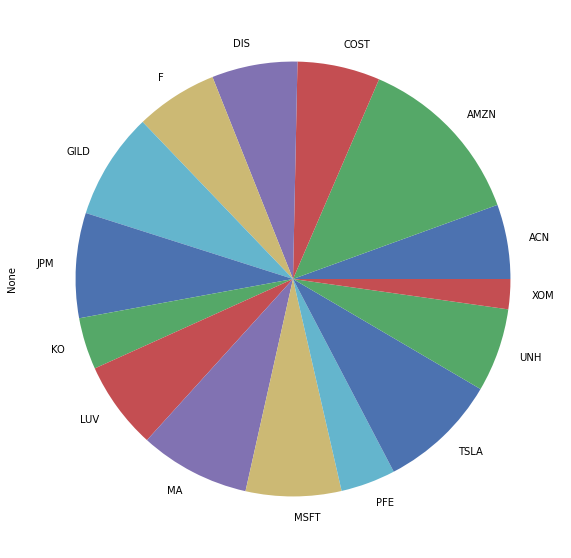

In [85]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [86]:
ef.portfolio_performance(verbose=True);

Expected annual return: 24.7%
Annual volatility: 14.8%
Sharpe Ratio: 1.53


The resulting portfolio still has a volatility of less than our 15% limit. It's in-sample Sharpe ratio has gone down, but this portfolio is a lot more robust for actual investment.

## Minimise risk for a given return, market-neutral

We may instead be in the situation where we have a certain required rate of return (maybe we are a pension fund that needs 7% return a year), but would like to minimise risk. Additionally, suppose we would like our portfolio to be market neutral, in the sense that it is equally exposed to the long and short sides.  

In [12]:
from pypfopt import objective_functions
# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.07, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', -0.03855),
             ('AMZN', 0.22031),
             ('COST', -0.0636),
             ('DIS', 0.00247),
             ('F', 0.00753),
             ('GILD', 0.03479),
             ('JPM', 0.04685),
             ('KO', -0.14778),
             ('LUV', 0.00569),
             ('MA', 0.04468),
             ('MSFT', 0.02178),
             ('PFE', -0.09037),
             ('TSLA', 0.13406),
             ('UNH', -0.01788),
             ('XOM', -0.15999)])

In [88]:
ef.portfolio_performance(verbose=True);

Expected annual return: 7.0%
Annual volatility: 10.6%
Sharpe Ratio: 0.47


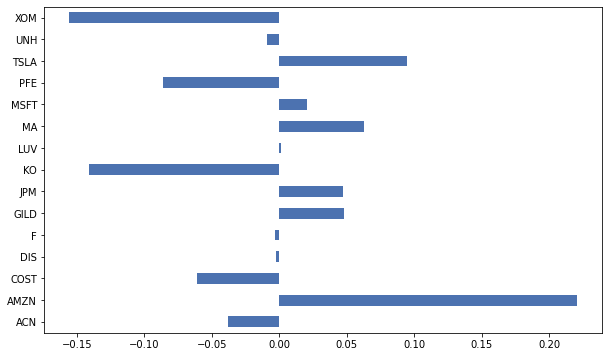

In [89]:
pd.Series(weights).plot.barh(figsize=(10,6));

In [90]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: -0.00


## Efficient semi-variance optimization

In this example, we will minimise the portfolio semivariance (i.e downside volatility) subject to a return constraint (target 20%).

There are actually two ways of doing this in PyPortfolioOpt. The first is the "intuitive" way. We compute a semicovariance matrix, and pass this into `EfficientFrontier` (just like we would do for the exponential cov matrix or the Ledoit-Wolf shrunk matrix).

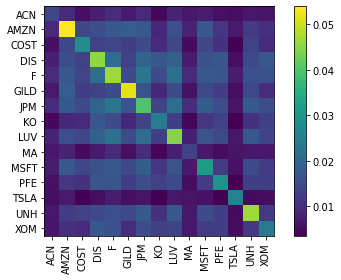

In [91]:
semicov = risk_models.semicovariance(prices, benchmark=0)
plotting.plot_covariance(semicov);

In [92]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights


OrderedDict([('ACN', 0.25802),
             ('AMZN', 0.0),
             ('COST', 0.08907),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.0098),
             ('JPM', 0.0),
             ('KO', 0.1331),
             ('LUV', 0.0),
             ('MA', 0.30826),
             ('MSFT', 0.0),
             ('PFE', 0.04855),
             ('TSLA', 0.14339),
             ('UNH', 0.0),
             ('XOM', 0.00981)])

In [93]:
ef.portfolio_performance(verbose=True);

Expected annual return: 22.5%
Annual volatility: 9.0%
Sharpe Ratio: 2.29


However, this solution is not truly optimal in mean-semivariance space. To do the optimization properly, we must use the `EfficientSemivariance` class. This requires us to first compute the returns and drop NaNs.

In [94]:
returns = expected_returns.returns_from_prices(prices)
returns = returns.dropna()

In [95]:
from pypfopt import EfficientSemivariance

es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)
es.portfolio_performance(verbose=True);


Expected annual return: 20.0%
Annual semi-deviation: 10.1%
Sortino Ratio: 1.78


To compare this with the heuristic solution, I will use a quick hack: replacing the `es.weights` with `es.weights` and running `es.portfolio_performance` again. Please don't be encouraged to do this in real life!

In [96]:
es.weights = ef.weights
es.portfolio_performance(verbose=True);

Expected annual return: 22.5%
Annual semi-deviation: 14.0%
Sortino Ratio: 1.47


We see that the heuristic method has a significantly lower Sortino ratio, and much higher semivariance.

## Efficient CVaR optimization

In this example, we will find the portfolio that maximises return subject to a CVaR constraint.

Before doing this, let's first compute the 95%-CVaR for the max-sharpe portfolio.

In [12]:
returns = expected_returns.returns_from_prices(prices).dropna()
returns.head()

Ticker,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-21,0.036831,0.004029,0.009479,-0.009198,0.007894,0.021039,0.012767,0.009383,-0.012092,-0.016466,...,0.010600,0.022975,0.015227,0.007570,0.023148,0.006068,0.013333,0.010751,0.012900,0.004258
2019-03-22,-0.020708,-0.027047,-0.021105,-0.028253,-0.032000,-0.032645,-0.022247,-0.022008,-0.003957,-0.007758,...,-0.007956,-0.026368,-0.066129,-0.008098,0.003944,-0.019562,-0.017522,0.025218,-0.018711,-0.007874
2019-03-25,-0.012091,-0.000589,-0.003837,0.022890,0.012406,-0.003839,-0.000190,-0.001625,-0.004066,0.011317,...,0.000729,0.005211,0.001703,0.002951,0.000371,-0.000931,-0.000261,0.005355,-0.011537,-0.001119
2019-03-26,-0.010332,0.009004,0.004219,-0.000216,0.003501,-0.009199,0.009482,0.010090,0.021802,-0.006104,...,0.006922,0.002125,0.012753,0.010396,0.000222,-0.014057,0.014834,0.009155,0.003729,0.001528
2019-03-27,0.008994,-0.010357,-0.004749,0.010341,-0.004854,-0.026851,-0.001691,-0.010795,0.001271,0.025589,...,-0.007598,-0.009668,-0.003478,-0.001165,0.010150,-0.006902,-0.006954,0.004123,0.005006,-0.011290


In [13]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 24.8%
Annual volatility: 9.5%
Sharpe Ratio: 2.41


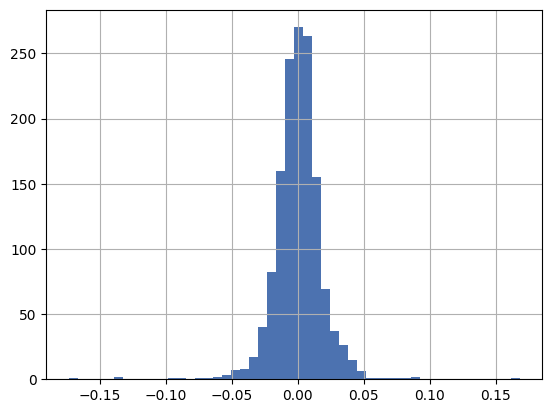

In [18]:
# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50);
plt.show()

In [100]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -2.13%
CVaR: -3.24%


This value of the CVaR means that our average loss on the worst 5% of days will be -3.35%. Let's say that this were beyond our comfort zone (for a \\$100,000 portfolio, this would mean losing \\$3350 in a day).

Let's firstly construct the portfolio with the minimum CVaR:

In [101]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);

Expected annual return: 18.1%
Conditional Value at Risk: 2.11%


We have significantly reduced the CVaR, but at the cost of a large reduction in returns. We can use `efficient_risk` to maximise the return for a target risk. Let's say that a 2.5% CVaR is acceptable.

In [102]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025)
ec.portfolio_performance(verbose=True);

Expected annual return: 25.0%
Conditional Value at Risk: 2.50%


We now have similar returns to before (24.7% vs 25.8%), but with a lower tail risk (2.50% CVaR vs 3.35%). 

## Plotting - Unconstrained

To plot the unconstrained efficient frontier, it is easiest to use the critical line algorithm. 

In [13]:
from pypfopt import CLA

cla = CLA(mu, S)
cla.min_volatility()
cla.portfolio_performance(verbose=True)

Expected annual return: 20.8%
Annual volatility: 12.3%
Sharpe Ratio: 1.52


(0.20754597987726447, 0.12347165931111563, 1.5189394952950188)

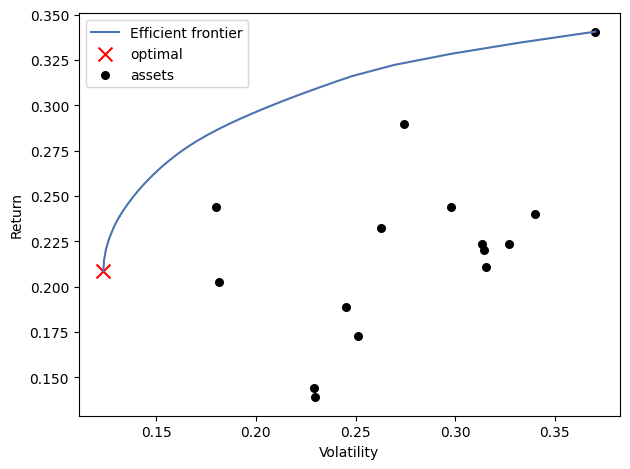

In [20]:
ax = plot_efficient_frontier(cla, showfig=False)

## Plotting - Constrained

In this example, we will plot the efficient frontier corresponding to portfolios with a constraint on exposure to MSFT, AMZN, and TSLA (e.g maybe we want to avoid big tech).

In [21]:
import cvxpy as cp

mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S,)
big_tech_indices = [t in {"MSFT", "AMZN", "TSLA"} for t in tickers]


As per the docs, *before* we call any optimization function, we should pass this to the plotting module:

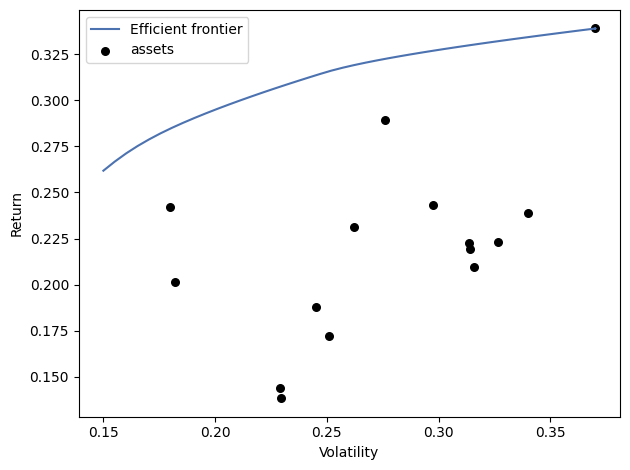

In [23]:
ax = plot_efficient_frontier(ef, ef_param="risk", 
                                      ef_param_range=np.linspace(0.15, 0.4, 50), 
                                      points=100_000,
                                      showfig=False);

<Axes: title={'center': 'Efficient Frontier with random portfolios'}, xlabel='Volatility', ylabel='Return'>

## Complex plots

The `plotting` module allows you to pass in an `ax`, on top of which the plots are added. This allows you to build complex plots. 

In this example, we will plot the efficient frontier as well as 10,000 simulated portfolios. 

To generate the simulated portfolios, we will sample random weights from the Dirichlet distribution (these are already normalised):

In [73]:
n_samples = 10_000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.23050696 0.21201501 0.22817495 ... 0.18358628 0.2356306  0.22478042]
Sample portfolio volatilities: 0       0.157926
1       0.166839
2       0.144429
3       0.210074
4       0.176034
          ...   
9995    0.176310
9996    0.168816
9997    0.155056
9998    0.160599
9999    0.174680
Length: 10000, dtype: float64


Note that the above code is equivalent to generating samples via a for loop (just more efficient)

In [74]:
cla = CLA(mu, S)
cla.min_volatility()
ret_min_variance,std_min_variance,_= cla.portfolio_performance(verbose=True)

Expected annual return: 20.8%
Annual volatility: 13.9%
Sharpe Ratio: 1.36


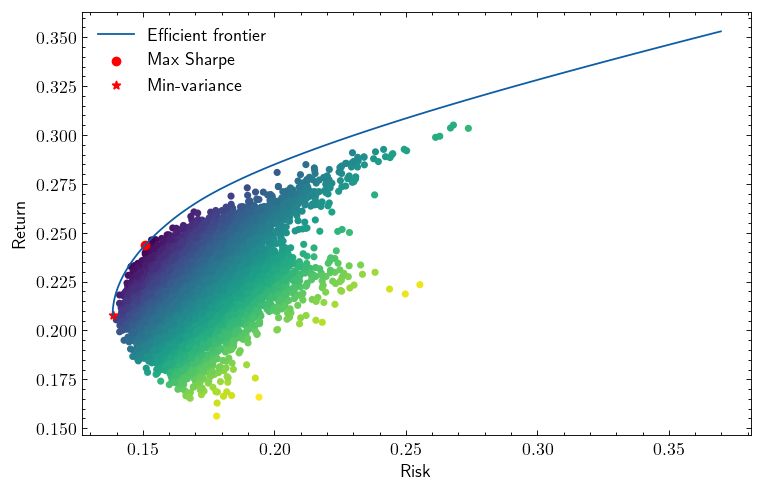

In [77]:
import scienceplots
%matplotlib inline

with plt.style.context('science','ieee'):
    fig, ax = plt.subplots(figsize=(6,4), dpi=128)
    ef = EfficientFrontier(mu, S)
    plot_efficient_frontier(ef, ax=ax, show_assets=False)
    ef = EfficientFrontier(mu, S)
    ef.max_sharpe()
    ret_tangent, std_tangent, _ = ef.portfolio_performance()
    ax.scatter(stds, rets, marker=".", c=sharpes,cmap="viridis_r")
    ax.scatter(std_tangent, ret_tangent, marker="o", s=20, c="r", label="Max Sharpe")
    ax.scatter(std_min_variance, ret_min_variance, marker="*", s=20, c="r", label="Min-variance")
    ax.set_xlabel('Risk')
    ax.set_ylabel('Return')
    
    plt.legend()


In [78]:
import numpy as np

# Preallocate an array of size 100
buffer_size = 100
buffer = np.empty(buffer_size)
index = 0  # To track the position for the next insertion
count = 0  # To track the number of elements added (up to `buffer_size`)

# Function to add a number (e.g., return value) to the buffer
def add_number(value):
    global index, count
    buffer[index] = value
    index = (index + 1) % buffer_size  # Wrap around when reaching the end
    count = min(count + 1, buffer_size)  # Keep count within buffer_size

# Function to calculate mean, std, and Sharpe ratio for the buffer
def calc_stats(risk_free_rate=0.0):
    if count == 0:
        return None, None, None  # No elements, return None
    valid_data = buffer[:count] if count < buffer_size else buffer
    mean_return = np.mean(valid_data)
    std_return = np.std(valid_data)
    sharpe_ratio = (mean_return - risk_free_rate) / std_return if std_return > 0 else 0
    return mean_return, std_return, sharpe_ratio

# Example usage
for i in range(120):  # Simulate adding 120 returns, only the last 100 will be kept
    add_number(np.random.normal(0.01, 0.02))  # Simulated return values

risk_free_rate = 0.001  # Example risk-free rate (e.g., 0.1% per period)
mean, std, sharpe = calc_stats(risk_free_rate)
print("Mean Return:", mean)
print("Standard Deviation:", std)
print("Sharpe Ratio:", sharpe)


Mean Return: 0.010877756824451485
Standard Deviation: 0.01894774494352453
Sharpe Ratio: 0.5213156950282493
